#Please run first to download all packages that are required

Read the PDF for more instructions

In [ ]:
!pip install git+https://github.com/mkelley/mskpy.git
!pip install sbpy
!pip install astroscrappy
!pip install ccdproc
!pip install astropy
!pip install photutils
!pip install tabulate
!pip install pandas
!pip install ipywidgets
!pip install matplotlib
!pip install tk

  Cloning https://github.com/mkelley/mskpy.git to /tmp/pip-req-build-bfythqs6
  Running command git clone --filter=blob:none --quiet https://github.com/mkelley/mskpy.git /tmp/pip-req-build-bfythqs6
  Resolved https://github.com/mkelley/mskpy.git to commit 6a30c913c8d8181729c7ca3ff5582910c73442a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.0/915.0 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.6 MB/s eta 0:00:00
  Created wheel for mskpy: filename=mskpy-3.0.12.dev50+g6a30c91-py3-none-any.whl size=851892 sha256=36cbf262f290208bbc0e7b9cbd0c82d8fa528d691bbf52cffb39ad8b56a37be6
  

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Specify the directory path to the FITS files that were processed
dir_path = '/content/drive/MyDrive/Colab Notebooks/Research/Jan20'

Mounted at /content/drive


#Image Reduction: Can take awhile to run

In [ ]:
import numpy as np
from astropy.io import fits
from astroscrappy import detect_cosmics
import os
from scipy.ndimage import generic_filter, convolve, median_filter

#Define function to interpolate bad colmuns

def interpolate_bad_columns(image, bad_columns):
    for col in bad_columns:
        if col == 0:
            image[:, col] = image[:, col + 1]  # Use the next column if the first column is bad
        elif col == image.shape[1] - 1:
            image[:, col] = image[:, col - 1]  # Use the previous column if the last column is bad
        else:
            # Use the average of the neighboring columns for interpolation
            image[:, col] = (image[:, col - 1] + image[:, col + 1]) / 2
    return image

# Mount the Google Drive to access files
drive.mount('/content/drive')

# Parameters for bad pixel mask
sigclip = 3. #5.0 is default
sigfrac = 0.3 #0.3 is default
objlim = 3 #5 is default

# Parameters for image cropping
# Set to 0 to not crop on left side. If not needed. Change the right size to the width of the image 2048 is standard.
crop_left_size = 0   # Number of pixels to crop from the left side of the image
crop_right_size = 2048  # Number of pixels to crop from the right side of the image

# Size parameter for replacing NaN values. Think of it as a window of size = (box_size x box_size)
box_size = 2  # Each integer number corresponds to one pixel. Make the box smaller than the pixel width of your streak. As I find it is best

# Change the current directory
os.chdir(dir_path)

# Create a separate folder for saving the final files
output_folder = os.path.join(dir_path, 'final_files')
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file containing the input list
csv_filename = dir_path+'/list.csv'

input_list = np.loadtxt(csv_filename, dtype={'names':('date','filenum', 'type'), 'formats':('U6','U6', 'U6')}, delimiter=',')

imtypes = np.array(input_list['type'])
biasims, = np.where(imtypes == 'bias')
flatims, = np.where(imtypes == 'flat')
dataims, = np.where(imtypes == 'data')

print(f'The number of DATA images to be processed is',len(dataims))

# Process the bias frames
bias_stack = []
for bb in range(len(biasims)):
    filename = str(input_list['date'][biasims][bb]) + '_' + str(input_list['filenum'][biasims][bb]) + '.fits'
    #Grab each bias and apply cosmic ray removal tool
    cosmic_corr = detect_cosmics(fits.getdata(filename), sigclip=5, gain=1.6, readnoise=5.87, verbose=False)
    bias_stack.append(cosmic_corr[1])

    # Save the processed bias frames and the associated cosmic ray mask
    hdud = fits.PrimaryHDU(cosmic_corr[1])
    hdud.writeto(os.path.join(output_folder, 'processed_bias_' + str(input_list['filenum'][biasims][bb]) + '.fits'), overwrite=True)
    hdud = fits.PrimaryHDU(cosmic_corr[0].astype(float))
    hdud.writeto(os.path.join(output_folder, 'mask_bias_' + str(input_list['filenum'][biasims][bb]) + '.fits'), overwrite=True)

# Create a master bias frame by taking the median of all bias frames
masterBias = np.median(bias_stack, axis=0)
hdud = fits.PrimaryHDU(masterBias)
hdud.writeto(os.path.join(output_folder, 'masterbias.fits'), overwrite=True)

# Process the flat frames
flat_stack = []
for dd in range(len(flatims)):
    filename = str(input_list['date'][flatims][dd]) + '_' + str(input_list['filenum'][flatims][dd]) + '.fits'
    print(f'Current filename being processed is',filename)
    flat_biassub = fits.getdata(filename) - masterBias

    # Apply cosmic ray detection and correction to the flat frames
    cosmic_corr = detect_cosmics(flat_biassub, sigclip=5, gain=1.6, readnoise=5.87, verbose=False)
    flat_stack.append(cosmic_corr[1])

    # Save the processed flat frames and the associated cosmic ray mask
    hdud = fits.PrimaryHDU(cosmic_corr[1])
    hdud.writeto(os.path.join(output_folder, 'processed_' + str(input_list['filenum'][flatims][dd]) + '.fits'), overwrite=True)
    hdud = fits.PrimaryHDU(cosmic_corr[0].astype(float))
    hdud.writeto(os.path.join(output_folder, 'mask_' + str(input_list['filenum'][flatims][dd]) + '.fits'), overwrite=True)

# Create a master flat frame by taking the median of all flat frames and normalize it
meanFlat = np.median(flat_stack, axis=0)
masterFlat = meanFlat / np.median(meanFlat)

# Crop the master flat frame based on the specified cropping parameters
masterFlat_cropped = masterFlat[:, crop_left_size:crop_right_size]

hdud = fits.PrimaryHDU(masterFlat_cropped)
hdud.writeto(os.path.join(output_folder, 'masterflat.fits'), overwrite=True)

# Process the data frames
for ii in range(len(dataims)):
    filename = str(input_list['date'][dataims][ii]) + '_' + str(input_list['filenum'][dataims][ii]) + '.fits'
    print(f'Current filename being processed is',filename)

    inital_data_image=fits.getdata(filename)

    # Create Bad Pixel Mask for the inital DATA image to remove cosmic rays FIRST
    # data_corr[0] is the mask data[1] is the cleaned image

    data_corr = detect_cosmics(inital_data_image, gain=1.6, readnoise=5.87, verbose=False)

    hdud = fits.PrimaryHDU(data_corr[1])
    hdud.writeto(os.path.join(output_folder, 'processed_inital_data' + str(input_list['filenum'][dataims][ii]) + '.fits'), overwrite=True)
    hdud = fits.PrimaryHDU(data_corr[0].astype(float))
    hdud.writeto(os.path.join(output_folder, 'mask_inital_data' + str(input_list['filenum'][dataims][ii]) + '.fits'), overwrite=True)

    # Create Bad Pixel Mask for final image
    object_biassub = data_corr[1] - masterBias
    cosmic_corr = detect_cosmics(object_biassub, gain=1.6, readnoise=5.87, verbose=False)

    hdud = fits.PrimaryHDU(cosmic_corr[0].astype(float))
    hdud.writeto(os.path.join(output_folder, 'mask_' + str(input_list['filenum'][dataims][ii]) + '.fits'), overwrite=True)

    # Apply flat field correction to the data frames
    flat_corr = cosmic_corr[1][:, crop_left_size:crop_right_size] / masterFlat_cropped

    ###########################################################
    # Comment this section out if there are no streaks
    ### Define the pixel range of the streaks
    #start_column = 1105  # Starting column of the streaks
    #end_column = 1110    # Ending column of the streaks
    #start_column_2 = 1448  # Starting column of the streaks
    #end_column_2 = 1453    # Ending column of the streaks

    ### Apply median filter only to the streak region
    #flat_corr[:, start_column:end_column]= 0
    #flat_corr[:, start_column_2:end_column_2]= 0
    ###########################################################

    # Calculate the median value of each column
    column_medians = np.median(flat_corr, axis=0)

    # Identify bad columns (e.g., where the value deviates more than 5% from the median)
    threshold = 0.05
    bad_columns = np.where(np.abs(column_medians - np.median(column_medians)) > threshold * np.median(column_medians))[0]
    corrected_finalimg = interpolate_bad_columns(flat_corr, bad_columns)

    hdud = fits.PrimaryHDU(corrected_finalimg)
    hdud.writeto(os.path.join(output_folder, 'processed_' + str(input_list['date'][dataims][ii]) + '_' + str(input_list['filenum'][dataims][ii]) + '.fits'), overwrite=True)
print('------------------------------------------------------------------------')
print(f'Images are location in',output_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of DATA images to be processed is 20
Current filename being processed is 012023_0001.fits
Current filename being processed is 012023_0002.fits
Current filename being processed is 012023_0003.fits
Current filename being processed is 012023_0004.fits
Current filename being processed is 012023_0005.fits
Current filename being processed is 012023_0006.fits
Current filename being processed is 012023_0007.fits
Current filename being processed is 012023_0008.fits
Current filename being processed is 012023_0009.fits
Current filename being processed is 012023_0010.fits
Current filename being processed is 012023_0011.fits
Current filename being processed is 012023_0038.fits
Current filename being processed is 012023_0039.fits
Current filename being processed is 012023_0040.fits
Current filename being processed is 012023_0041.fits
Current filename being proce

#Photometry (If running after image reduction you may need to wait for the files to be found by this code. Since they take a couple minutes to upload)

* Need to add the background subtracted flux annulus as well to show if the size is alright

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Do you wish to skip aperture graphs for stars? (y/n): n


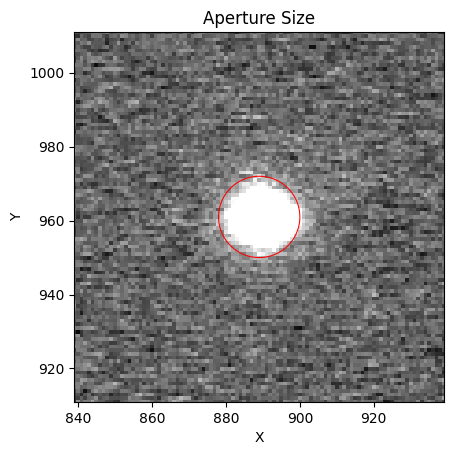

Does the aperture size look good? (y/n): y
radii is now [11.0]
---------------------------------------
Do you wish to skip aperture graphs for the rest of the stars? (y/n): n

Fluxcal Image
--------------
File: /content/drive/MyDrive/Colab Notebooks/Research/Jan20/final_files/processed_012023_0038.fits

╒══════╤════════════╤════════════╤═══════════════════════════╤════════════════════╤═══════════════════════╤══════════════════════════════╕
│   ID │ X Center   │ Y Center   │   Aperture Sum Background │   Aperture Sum Err │   Aperture Background │   Background-Subtracted Flux │
╞══════╪════════════╪════════════╪═══════════════════════════╪════════════════════╪═══════════════════════╪══════════════════════════════╡
│    1 │ 889.0 pix  │ 961.0 pix  │                    118587 │            363.156 │              -2760.25 │                       121347 │
╘══════╧════════════╧════════════╧═══════════════════════════╧════════════════════╧═══════════════════════╧══════════════════════════════╛


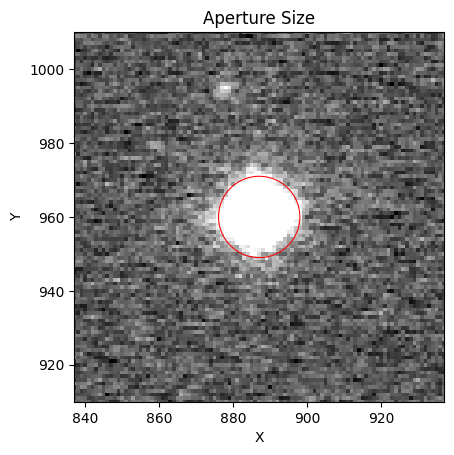

Does the aperture size look good? (y/n): y
radii is now [11.0]
---------------------------------------
Do you wish to skip aperture graphs for the rest of the stars? (y/n): n

Fluxcal Image
--------------
File: /content/drive/MyDrive/Colab Notebooks/Research/Jan20/final_files/processed_012023_0039.fits

╒══════╤════════════╤════════════╤═══════════════════════════╤════════════════════╤═══════════════════════╤══════════════════════════════╕
│   ID │ X Center   │ Y Center   │   Aperture Sum Background │   Aperture Sum Err │   Aperture Background │   Background-Subtracted Flux │
╞══════╪════════════╪════════════╪═══════════════════════════╪════════════════════╪═══════════════════════╪══════════════════════════════╡
│    1 │ 887.0 pix  │ 960.0 pix  │                    197580 │            459.046 │              -2554.41 │                       200134 │
╘══════╧════════════╧════════════╧═══════════════════════════╧════════════════════╧═══════════════════════╧══════════════════════════════╛


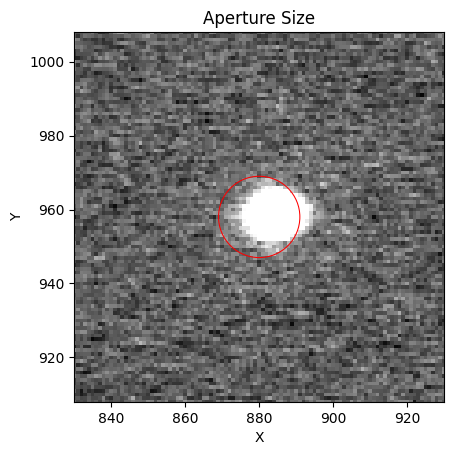

Does the aperture size look good? (y/n): n
Enter the new aperture size: 15
Enter the new offest to view large or small images default is 50: 50


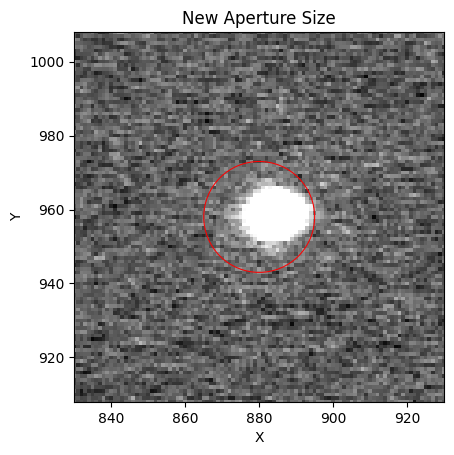

radii is now [15.0]
---------------------------------------
Do you wish to skip aperture graphs for the rest of the stars? (y/n): y

Fluxcal Image
--------------
File: /content/drive/MyDrive/Colab Notebooks/Research/Jan20/final_files/processed_012023_0040.fits

╒══════╤════════════╤════════════╤═══════════════════════════╤════════════════════╤═══════════════════════╤══════════════════════════════╕
│   ID │ X Center   │ Y Center   │   Aperture Sum Background │   Aperture Sum Err │   Aperture Background │   Background-Subtracted Flux │
╞══════╪════════════╪════════════╪═══════════════════════════╪════════════════════╪═══════════════════════╪══════════════════════════════╡
│    1 │ 880.0 pix  │ 958.0 pix  │                   47423.3 │             276.39 │               -5262.3 │                      52685.6 │
╘══════╧════════════╧════════════╧═══════════════════════════╧════════════════════╧═══════════════════════╧══════════════════════════════╛

Fluxcal Image
--------------
File: /conten

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from tabulate import tabulate
import pandas as pd
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import time

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load input CSV file/textfile
csv_filename = dir_path+'/list_photometry.csv'  # Replace with the actual path to your CSV file/ make sure columns are formatted correctly
input_list = np.loadtxt(csv_filename, dtype={'names':('date','filenum', 'type', 'x', 'y'), 'formats':('U6','U6','U6', 'U6', 'U6')}, delimiter=',')

dir_path_final_files=dir_path+'/final_files'

# Function to plot aperture and get user feedback
def plot_aperture(data, position, radius):
    fig, ax = plt.subplots()
    # Create the object for ZScaleInterval
    z = ZScaleInterval()
    # Get min and max values of the M31 data
    z1, z2 = z.get_limits(data)
    #Offset to make the box around the aperture
    offset = 50
    # Plot the image with the aperture
    ax.imshow(data, cmap='gray', origin='lower', vmin=z1, vmax=z2)
    aperture = CircularAperture(position, r=radius[0])
    aperture.plot(color='red', lw=0.75, ax=ax)
    ax.set_xlim(position[0]-offset, position[0]+offset)
    ax.set_ylim(position[1]-offset, position[1]+offset)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Aperture Size')
    plt.show()

    time.sleep(1)

    # Ask user if the aperture size looks good
    response = input("Does the aperture size look good? (y/n): ")
    if response == 'n':
        new_radius=[1.]
        new_radius_entry = float(input("Enter the new aperture size: "))
        new_radius[0]=new_radius_entry

        fig, ax = plt.subplots()
        # Create the object for ZScaleInterval
        z = ZScaleInterval()
        # Get min and max values of the M31 data
        z1, z2 = z.get_limits(data)
        #Offset to make the box around the aperture
        offset = float(input("Enter the new offest to view large or small images default is 50: "))
        # Plot the image with the aperture
        ax.imshow(data, cmap='gray', origin='lower', vmin=z1, vmax=z2)
        aperture = CircularAperture(position, r=new_radius[0])
        aperture.plot(color='red', lw=0.75, ax=ax)
        ax.set_xlim(position[0]-offset, position[0]+offset)
        ax.set_ylim(position[1]-offset, position[1]+offset)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('New Aperture Size')
        plt.show()

        time.sleep(1)
        return new_radius
    return radius

#skip the aperture process
skip_response = input("Do you wish to skip aperture graphs for stars? (y/n): ")

# Process fluxcal images
fluxcal_indices = np.where(input_list['type'] == 'star')[0]
fluxcal_data = []  # List to store fluxcal table data
for ii in fluxcal_indices:
    filename = f'{dir_path_final_files}/processed_{input_list["date"][ii]}_{input_list["filenum"][ii]}.fits'
    data = fits.getdata(filename)

    position = [float(input_list['x'][ii]) - 1, float(input_list['y'][ii]) - 1]
    radii = [11.]  # Radii containing only comet or flux star (15)
    rad = [20., 30.]  # Inner and outer radii of background (20,30)

    # Plot and possibly update aperture size
    if skip_response != 'y':
      radii = plot_aperture(data, position, radii)
      print(f'radii is now {radii}')
      print('---------------------------------------')
      skip_response = input("Do you wish to skip aperture graphs for the rest of the stars? (y/n): ")

    aperture = [CircularAperture(position, r=r) for r in radii]

    annulus = CircularAnnulus(position, rad[0], rad[1])
    masks = annulus.to_mask(method='center')
    annulus_data = masks.multiply(data)

    mask = masks.data
    annulus_data_1d = annulus_data[mask > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)

    background = [median_sigclip * a.area for a in aperture]

    img_error = np.sqrt(abs(data) + (5.87 ** 2.0))

    ptable = aperture_photometry(data, aperture[0], error=img_error)
    ptable['aper_bkg'] = median_sigclip * aperture[0].area
    ptable['aper_sum_bkgsub'] = ptable['aperture_sum'] - ptable['aper_bkg']  # bkg subtracted flux

    print("\nFluxcal Image")
    print("--------------")
    print(f"File: {filename}\n")
    headers = ["ID", "X Center", "Y Center", "Aperture Sum Background", "Aperture Sum Err", "Aperture Background", "Background-Subtracted Flux"]
    rows = []
    for i, aper in enumerate(aperture):
        row = [
            i + 1,
            ptable['xcenter'][i],
            ptable['ycenter'][i],
            ptable['aperture_sum'][i],
            ptable['aperture_sum_err'][i],
            ptable['aper_bkg'][i],
            ptable['aper_sum_bkgsub'][i]
        ]
        rows.append(row)
        fluxcal_data.append(row)

    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

# Convert fluxcal_data to a DataFrame
fluxcal_df = pd.DataFrame(fluxcal_data, columns=headers)

# Save fluxcal DataFrame as CSV file
fluxcal_df.to_csv(dir_path+'/final_files/fluxcal_table.csv', index=False)

skip_response = input("Do you wish to skip aperture graphs for comets? (y/n): ")

# Process comet images
comet_indices = np.where(input_list['type'] == 'comet')[0]
comet_data = []  # List to store comet table data
for jj in comet_indices:
    filename = f'{dir_path_final_files}/processed_{input_list["date"][jj]}_{input_list["filenum"][jj]}.fits'
    data = fits.getdata(filename)

    position = [float(input_list['x'][jj]) - 1, float(input_list['y'][jj]) - 1]
    radii = [20.]  # Radii containing only comet (26)
    rad = [125., 250.] # (400,600)

    # Plot and possibly update aperture size
    if skip_response != 'y':
      radii = plot_aperture(data, position, radii)
      print(f'radii is now {radii}')
      print('---------------------------------------')
      skip_response = input("Do you wish to skip aperture graphs for the rest of the comets? (y/n): ")

    aperture = [CircularAperture(position, r=r) for r in radii]

    annulus = CircularAnnulus(position, rad[0], rad[1])
    masks = annulus.to_mask(method='center')
    annulus_data = masks.multiply(data)

    mask = masks.data
    annulus_data_1d = annulus_data[mask > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)

    background = [median_sigclip * a.area for a in aperture]

    img_error = np.sqrt(abs(data) + (5.87 ** 2.0))

    ptable = aperture_photometry(data, aperture[0], error=img_error)
    ptable['aper_bkg'] = median_sigclip * aperture[0].area
    ptable['aper_sum_bkgsub'] = ptable['aperture_sum'] - ptable['aper_bkg']  # bkg subtracted flux

    # print(ptable['aperture_sum_err'])

    # Uncomment the following lines if needed for background annulus photometry
    # bkg_ap = CircularAperture(position, rad[1])
    # ptable2 = aperture_photometry(annulus_data, bkg_ap, error=bkg_error)
    # print(annulus_data.shape)

    # uncert = np.sqrt(ptable['aperture_sum_err'] ** 2 + ptable2['aperture_sum_err'] ** 2)
    # print(uncert)
    print("\nComet Image")
    print("-----------")
    print(f"File: {filename}\n")
    headers = ["ID", "X Center", "Y Center", "Aperture Sum Background", "Aperture Sum Err", "Aperture Background", "Background-Subtracted Flux"]
    rows = []
    for i, aper in enumerate(aperture):
        row = [
            i + 1,
            ptable['xcenter'][i],
            ptable['ycenter'][i],
            ptable['aperture_sum'][i],
            ptable['aperture_sum_err'][i],
            ptable['aper_bkg'][i],
            ptable['aper_sum_bkgsub'][i]
        ]
        rows.append(row)
        comet_data.append(row)

    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

# Convert comet_data to a DataFrame
comet_df = pd.DataFrame(comet_data, columns=headers)

# Save comet DataFrame as CSV file
comet_df.to_csv(dir_path+'/final_files/comet_table.csv', index=False)

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import os
%matplotlib inline
import matplotlib.pyplot as plt

# Change the current directory
os.chdir(dir_path)

# Create a separate folder for saving the final files
output_folder = os.path.join(dir_path, 'final_files')
image_file = os.path.join(output_folder, 'processed_012023_0068.fits')
data = fits.getdata(image_file)

def plot_interactive(offset, r, x, y):
  # Plot the data with offset as parameters
  # Plotting code
  fig, ax = plt.subplots()
  # Create the object for ZScaleInterval
  z = ZScaleInterval()
  # Get min and max values of the M31 data
  z1, z2 = z.get_limits(data)
  #Offset to make the box around the aperture
  offset = int(offset)
  #radius
  radius = [11.]
  radius[0]=r

  #Change center point
  position = [x,y]
  print(f'x position is now {x} and y is {y}')

  # Plot the image with the aperture
  ax.imshow(data, cmap='gray', origin='lower', vmin=z1, vmax=z2)
  aperture = CircularAperture(position, r=radius[0])
  aperture.plot(color='red', lw=0.75, ax=ax)
  ax.set_xlim(position[0]-offset, position[0]+offset)
  ax.set_ylim(position[1]-offset, position[1]+offset)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Aperture Size')
  plt.show()
  print(f'radii is now {radius} and offset was set {offset}')
  return offset, radius

Fixing_Plots=interactive(plot_interactive, offset=(0,1000), r=(0,1000),x=(0,2048),y=(0, 2048))

In [ ]:
display(Fixing_Plots)

#Calibration

In [ ]:
#This code cell is for your convenience. To make doing photometry easier. Please put your star values in the correct spots.
#These will be used by the calibration code.
###To create the table below, enter the filter, the magnitude (m) of your standard in that filter (from Farnham et al.),
#and the airmass of for all your flux star observations on a given night. z is the zenith angle, which is just arccos(1/airmass).
#It seems that Mike used a more precise formula for z, I can find out what he used, but the difference is very small.
#Then you also need to convert your counts to an instrumental magnitude, which we discussed before.
import pandas as pd
import numpy as np

# Get 'Background-Subtracted Flux' and 'Aperture Sum Err' columns as lists from fluxcal_df
counts = fluxcal_df['Background-Subtracted Flux'].tolist()
counts_unc = fluxcal_df['Aperture Sum Err'].tolist()

# Define exposure time, air mass, and m values as lists
exposure_time = [5,2,180,20,10,10,5,2,180,20]
Air_Mass = [1.73,1.76,1.80,1.88,1.93,1.08,1.08,1.08,1.08,1.09]
m = [5.838,5.837,6.018,6.004,5.875,5.986,5.921,5.931,6.366,6.325]

# Create a dictionary containing the data NIGHT OF JAN 20
data = {
    'Number': [38,39,40,41,42,43,44,45,46,47],
    'Object': ['HD31331','HD31331','HD31331','HD31331','HD31331','HD68099','HD68099','HD68099','HD68099','HD68099'],
    'filter': ['BC','C2','OH','NH','CN','CN','BC','C2','OH','NH'],
    'airmass': Air_Mass,
    'exptime': exposure_time,
    'counts': counts,
    'counts_unc': counts_unc,
    'm': m,
    'm_inst': -2.5 * np.log10(np.array(counts) / np.array(exposure_time)),
    'm_inst unc': 2.5 * 0.434 * np.array(counts_unc) / np.array(counts),
    'z': np.degrees(np.arccos(1 / np.array(Air_Mass)))
}

# Create a DataFrame using the data dictionary
df_star = pd.DataFrame(data)

# Specify the directory path to save the file
save_dir = dir_path_final_files

# Save the DataFrame to a CSV file
df_star.to_csv(save_dir + '/photometry_data_star.csv', index=False)

# Optional: Print the DataFrame
df_star

,Number,Object,filter,airmass,exptime,counts,counts_unc,m,m_inst,m_inst unc,z
0,38,HD31331,BC,1.73,5,121411.605960,363.763148,5.838,-10.963225,0.003251,54.687569
1,39,HD31331,C2,1.76,2,200136.951349,459.266472,5.837,-12.500743,0.002490,55.376465
2,40,HD31331,OH,1.80,180,51906.684899,252.120864,6.018,-6.149877,0.005270,56.251011
3,41,HD31331,NH,1.88,20,131768.146753,377.643404,6.004,-9.546951,0.003110,57.865072
4,42,HD31331,CN,1.93,10,172886.988805,428.003491,5.875,-10.594406,0.002686,58.792785
5,43,HD68099,CN,1.08,10,212655.115427,472.433052,5.986,-10.819190,0.002410,22.191607
6,44,HD68099,BC,1.08,5,128783.011253,373.631735,5.921,-11.027221,0.003148,22.191607
7,45,HD68099,C2,1.08,2,200586.425186,459.617309,5.931,-12.503179,0.002486,22.191607
8,46,HD68099,OH,1.08,180,124722.021482,368.611890,6.366,-7.101677,0.003207,22.191607
9,47,HD68099,NH,1.09,20,163466.111236,417.280232,6.325,-9.780994,0.002770,23.446617


In [ ]:
#This code cell is for your convenience. To make doing photometry easier. Please put your comet values in the correct spots.
import pandas as pd
import numpy as np

#comet C/2022 E3

# Get the 'Background-Subtracted Flux' and 'Aperture Sum Err' columns from comet_df as lists
counts = comet_df['Background-Subtracted Flux'].tolist()
counts_unc = comet_df['Aperture Sum Err'].tolist()

# Define exposure time, air mass, and file_id values as lists
exposure_time = [60,60,300,300,60,300,300,300,900,600]
Air_Mass = [1.31,1.29,1.27,1.25,1.23,1.22,1.20,1.18,1.16,1.13]
file_id = [59,60,61,62,63,64,65,66,67,68]

# Create a dictionary to store the data for the comet NIGHT OF JAN 20
data_comet = {
    'Number': file_id,
    'filter': ['BC','C2','OH','NH','CN','CN','BC','C2','OH','NH'],
    'airmass': Air_Mass,
    'exptime': exposure_time,
    'counts': counts,
    'counts_unc': counts_unc,
}

# Create a DataFrame using the comet data
df_comet = pd.DataFrame(data_comet)

# Specify the directory path to save the file
save_dir = dir_path_final_files

# Save the DataFrame to a CSV file
df_comet.to_csv(save_dir + '/photometry_data_comet.csv', index=False)

# Optional: Print the DataFrame
df_comet

,Number,filter,airmass,exptime,counts,counts_unc
0,59,BC,1.31,60,3.667609e+04,258.535354
1,60,C2,1.29,60,3.406449e+05,635.386574
2,61,OH,1.27,300,3.735563e+04,265.898386
3,62,NH,1.25,300,7.195559e+04,343.134663
4,63,CN,1.23,60,1.522531e+05,443.596641
5,64,CN,1.22,300,1.184432e+05,468.689042
6,65,BC,1.20,300,7.348194e+04,336.263713
7,66,C2,1.18,300,1.911034e+06,1455.628403
8,67,OH,1.16,900,1.059912e+05,394.080851
9,68,NH,1.13,600,1.533462e+05,477.310892


Mounted at /content/drive


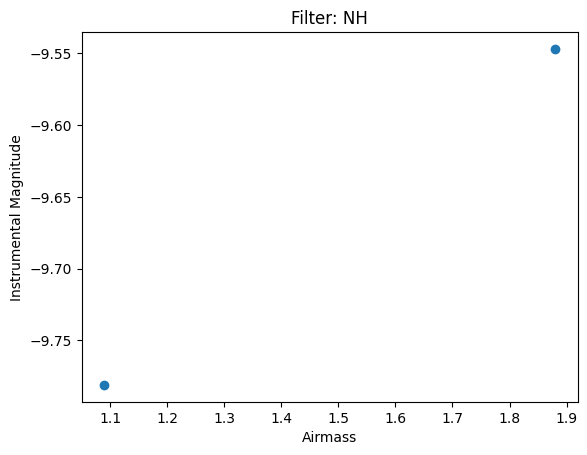

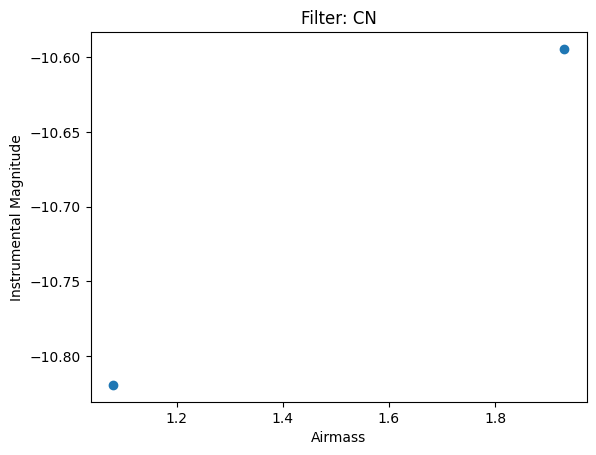

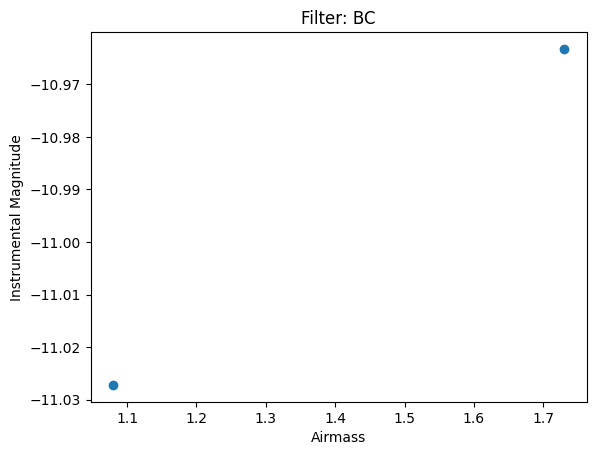

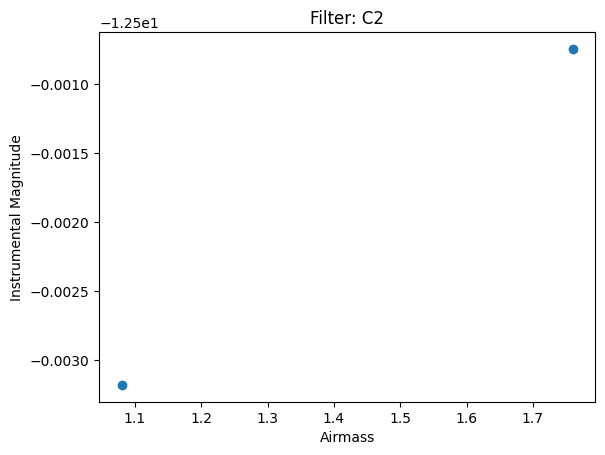

filter  N  magzp  magzp unc   Ex  Ex unc  toz  toz unc mean residuals stdev residuals standard error
------ --- ------ --------- ----- ------ ----- ------- -------------- --------------- --------------
    NH   2 16.872     0.008 0.703  0.005    --      --          0.000           0.000          0.000
    CN   2 17.232     0.006 0.395  0.004    --      --         -0.000           0.000          0.000
    BC   2 17.192     0.010 0.226  0.007    --      --         -0.000           0.000          0.000
    C2   2 18.587     0.008 0.142  0.005    --      --         -0.000           0.000          0.000
    OH   2 15.474     0.012    --     -- 0.236   0.003         -0.000           0.000          0.000
Values should be close: NH 10.043722365478665 0.011490675121419762
Values should be close: NH 10.059086369313018 0.010427611370783343
Values should be close: CN 8.2348960347946 0.008880863636315394
Values should be close: CN 10.258911777483991 0.009320323344263177
Values should be close: BC 9

In [ ]:
import numpy as np
import astropy.units as u
from astropy.io import ascii
from astropy.table import Table
from mskpy import photometry
from mskpy import comet
import math
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# At the end of your photometry code, convert your counts to an instrumental magnitude by the following:
# m_inst = -2.5 * log(counts / exptime)
# The uncertainty is tricky, since we have to propagate it through the log function.
# m_inst_unc = 2.5 * 0.434 * counts_unc / counts
# Technically the exposure time should be included, but it factors in to both counts_unc and counts, and therefore cancels out.

# Read the ASCII file for star
phot = ascii.read(save_dir + '/photometry_data_star.csv')

h = 2077 * u.m  # elevation of McDonald

# First, calibrate the easy filters
cal = []
for filt in ('NH', 'CN', 'BC', 'C2'):
    data = phot[phot['filter'] == filt]

    # calibrate magnitude with extinction proportional to airmass
    fit, fit_unc = photometry.cal_airmass(
        data['m_inst'], data['m_inst unc'], data['m'], data['airmass'])

    # best fit for each data point:
    model = (data['m'] - fit[0] + fit[1] * data['airmass'])

    # residuals from best fit:
    residuals = model - data['m_inst']

    plt.scatter(data['airmass'], data['m_inst'])
    plt.xlabel('Airmass')
    plt.ylabel('Instrumental Magnitude')
    plt.title(f'Filter: {filt}')
    plt.show()

    # save results
    # filter, N, magzp, magzp unc, Ex, Ex unc, toz, toz unc, mean residuals
    # stdev residuals, standard error
    cal.append((
        filt,
        len(data),
        fit[0],
        fit_unc[0],
        fit[1],
        fit_unc[1],
        np.ma.masked,  # ozone parameter not calculated
        np.ma.masked,
        np.mean(residuals),
        np.std(residuals, ddof=1),
        np.std(residuals, ddof=1) / np.sqrt(len(data))
    ))

# OH extinction has multiple components, here we use BC to help isolate the ozone component
data = phot[phot['filter'] == 'OH']
bc = cal[1]
Ex_BC = cal[1][4]

# see cal_oh for explanation of parameters and return values
fit, fit_unc = photometry.hb.cal_oh(
    data['m_inst'], data['m_inst unc'], data['m'], data['z'] * u.deg,
    'b', 'b', Ex_BC, h)

# use best-fit ozone parameter and BC extinction to calculate total extinction in OH
ext_oh = photometry.hb.ext_total_oh(fit[1], data['z'] * u.deg, 'b', 'b',
                                    Ex_BC, h)
model = data['m'] - fit[0] + ext_oh
residuals = model - data['m_inst']

# save results
cal.append((
    'OH',
    len(data),
    fit[0],
    fit_unc[0],
    np.ma.masked,  # not calculated for OH
    np.ma.masked,
    fit[1],
    fit_unc[1],
    np.mean(residuals),
    np.std(residuals, ddof=1),
    np.std(residuals, ddof=1) / np.sqrt(len(data))
))

cal = Table(
    rows=cal,
    names=['filter', 'N', 'magzp', 'magzp unc', 'Ex', 'Ex unc',
           'toz', 'toz unc', 'mean residuals', 'stdev residuals',
           'standard error'])

for col in cal.colnames[2:]:
    cal[col].format = '{:.3f}'

cal.pprint_all()

# Now we use these values to calibrate the comet photometry
phot_comet = ascii.read(save_dir + '/photometry_data_comet.csv')

M_cal_all = []
M_cal_all_unc = []
dust_filters = {}
dust_filters_unc = {}

for filt in ('NH', 'CN', 'BC', 'C2'):
    data = phot_comet[phot_comet['filter'] == filt]
    for i in range(len(data)):
        flux = float(data['counts'][i]) / float(data['exptime'][i])  # converts to counts/s
        M_inst = -2.5 * np.log10(flux)  # instrumental magnitude
        m_inst_unc = 2.5 * 0.434 * float(data['counts_unc'][i]) / float(data['counts'][i])
        K = float(cal['Ex'][cal['filter'] == filt])  # retrieve the appropriate extinction coefficient
        K_unc = float(cal['Ex unc'][cal['filter'] == filt])  # retrieve uncertainty in extinction coefficient
        M_0 = M_inst - K * float(data['airmass'][i])  # correct for the top of the atmosphere
        M_zp = cal['magzp'][cal['filter'] == filt]  # retrieve the appropriate zero point magnitude
        M_zp_unc = float(cal['magzp unc'][cal['filter'] == filt])  # retrieve uncertainty in zero point
        M_cal = M_0 + float(M_zp)  # calibrated magnitude
        M_cal_unc = np.sqrt(m_inst_unc ** 2.0 + M_zp_unc ** 2.0 + (float(data['airmass'][i]) * K_unc) ** 2.0)  # calculate uncertainty in calibrated magnitude
        M_cal_all.append(M_cal)
        M_cal_all_unc.append(M_cal_unc)
        print('Values should be close:', filt, M_cal, M_cal_unc)
        if filt == 'BC':
            if 'BC' not in dust_filters:
                dust_filters['BC'] = []
                dust_filters_unc['BC'] = []
            dust_filters['BC'].append(M_cal)
            dust_filters_unc['BC'].append(M_cal_unc)
# Convert the lists to single values for the 'BC' filter
dust_filters['BC'] = np.mean(dust_filters['BC'])
dust_filters_unc['BC'] = np.mean(dust_filters_unc['BC'])

print('dust_filters', dust_filters) #for debugging to insure that BC is defined right
print('dust_filters_unc', dust_filters_unc)

# The code below calculates the continuum color from two dust continuum measurements
color = [0, 0] * u.mag / u.Unit('0.1 um')

print('Dust Color is', color[0])
print('Dust Color Uncertainty is', color[1])

# Here using our derived (or assumed) dust color, we derive how much continuum is present in each filter of interest
continuum_estimates = photometry.hb.estimate_continuum('BC', dust_filters, unc=dust_filters_unc, Rm=color[0], Rm_unc=color[1])

NH_cont = continuum_estimates[0]['NH']
NH_cont_unc = continuum_estimates[1]['NH']
CN_cont = continuum_estimates[0]['CN']
CN_cont_unc = continuum_estimates[1]['CN']
C2_cont = continuum_estimates[0]['C2']
C2_cont_unc = continuum_estimates[1]['C2']
BC_cont = continuum_estimates[0]['BC']
BC_cont_unc = continuum_estimates[1]['BC']

fluxes = []
flux_uncertainties = []

#Has the order NH, CN, BC, C2

# Calculate NH flux and uncertainty
for i in range(0, 2):
    nh_flux = photometry.hb.F_0['NH'] * 10 ** (-0.4 * M_cal_all[i])
    nh_flux_unc = M_cal_all_unc[i] * nh_flux / 1.0857
    fluxes.append(nh_flux)
    flux_uncertainties.append(nh_flux_unc)

nh_flux_avg = sum(fluxes) / len(fluxes)
nh_flux_unc_avg = np.sqrt(sum(flux_uncertainties[i] ** 2 for i in range(len(flux_uncertainties)))) / len(fluxes)
NHflux_cal = photometry.hb.flux_gas(nh_flux_avg, nh_flux_unc_avg, NH_cont, NH_cont_unc, 'NH')

# Calculate CN flux and uncertainty
fluxes.clear()
flux_uncertainties.clear()

for i in range(2, 4):
    cn_flux = photometry.hb.F_0['CN'] * 10 ** (-0.4 * M_cal_all[i])
    cn_flux_unc = M_cal_all_unc[i] * cn_flux / 1.0857
    fluxes.append(cn_flux)
    flux_uncertainties.append(cn_flux_unc)

cn_flux_avg = sum(fluxes) / len(fluxes)
cn_flux_unc_avg = np.sqrt(sum(flux_uncertainties[i] ** 2 for i in range(len(flux_uncertainties)))) / len(fluxes)
CNflux_cal = photometry.hb.flux_gas(cn_flux_avg, cn_flux_unc_avg, CN_cont, CN_cont_unc, 'CN')

# Calculate BC flux and uncertainty
fluxes.clear()
flux_uncertainties.clear()

for i in range(4, 6):
    bc_flux = photometry.hb.F_0['BC'] * 10 ** (-0.4 * M_cal_all[i])
    bc_flux_unc = M_cal_all_unc[i] * bc_flux / 1.0857
    fluxes.append(bc_flux)
    flux_uncertainties.append(bc_flux_unc)

BCflux_cal = sum(fluxes) / len(fluxes)
BCflux_cal_unc_avg = np.sqrt(sum(flux_uncertainties[i] ** 2 for i in range(len(flux_uncertainties)))) / len(fluxes)

# Calculate C2 flux and uncertainty
fluxes.clear()
flux_uncertainties.clear()

for i in range(6, 8):
    c2_flux = photometry.hb.F_0['C2'] * 10 ** (-0.4 * M_cal_all[i])
    c2_flux_unc = M_cal_all_unc[i] * c2_flux / 1.0857
    fluxes.append(c2_flux)
    flux_uncertainties.append(c2_flux_unc)

c2_flux_avg = sum(fluxes) / len(fluxes)
c2_flux_unc_avg = np.sqrt(sum(flux_uncertainties[i] ** 2 for i in range(len(flux_uncertainties)))) / len(fluxes)
C2flux_cal = photometry.hb.flux_gas(c2_flux_avg, c2_flux_unc_avg, C2_cont, C2_cont_unc, 'C2')

# Time for the tricky one: OH

# This section initializes variables for input into flux_oh()
data = phot_comet[phot_comet['filter'] == 'OH']
print(data)
OHflux_cal_all = []
for i in range(len(data)):
    z = np.degrees(np.arccos(1.0 / float(data['airmass'][i])))  # calculate zenith angle
    Ex_BC = cal['Ex'][cal['filter'] == 'BC']
    toz = cal['toz'][cal['filter'] == 'OH']
    flux = float(data['counts'][i]) / float(data['exptime'][i])  # converts to counts/s
    M_inst_OH = -2.5 * np.log10(flux)  # instrumental magnitude
    m_inst_OH_unc = 2.5 * 0.434 * float(data['counts_unc'][i]) / float(data['counts'][i])
    M_zp_OH = cal['magzp'][cal['filter'] == 'OH']  # retrieve the appropriate zero point magnitude
    print(toz, Ex_BC)

    # This one line does A LOT, from figuring out the extinction and dust continuum contributions and deriving the absolute flux
    OHflux_cal = photometry.hb.flux_oh(M_inst_OH, m_inst_OH_unc, dust_filters, dust_filters_unc, M_zp_OH, float(toz), z * u.deg, float(Ex_BC), h, Rm=color[0], Rm_unc=color[1])
    OHflux_cal_all.append(OHflux_cal)

print('NH flux =', NHflux_cal[0], '+/-', NHflux_cal[1])
print('CN flux =', CNflux_cal[0], '+/-', CNflux_cal[1])
print('BC flux =', BCflux_cal, '+/-', BCflux_cal_unc_avg)
print('C2 flux =', C2flux_cal[0], '+/-', C2flux_cal[1])

for i in range(len(OHflux_cal_all)):
    print('OH flux =', OHflux_cal_all[i][4], '+/-', OHflux_cal_all[i][5])
    print('OH extinction =', OHflux_cal_all[i][0], '+/-', OHflux_cal_all[i][1] * u.mag)
    print('OH apparent magnitude =', OHflux_cal_all[i][2], '+/-', OHflux_cal_all[i][3] * u.mag)

# Initialize variables to store cumulative values
sum_flux = 0.0
sum_flux_uncertainty = 0.0
num_values = len(OHflux_cal_all)

# Iterate over the OH flux values
for i in range(num_values):
    flux = OHflux_cal_all[i][4]
    flux_uncertainty = OHflux_cal_all[i][5]

    # Accumulate the flux and uncertainty
    sum_flux += flux
    sum_flux_uncertainty += flux_uncertainty

# Calculate the average flux and uncertainty
average_flux_OH = sum_flux / num_values
average_flux_uncertainty_OH = sum_flux_uncertainty / num_values

# Print the average values
print('Average OH flux =', average_flux_OH, '+/-', average_flux_uncertainty_OH)

#Production Rate

In [ ]:
from IPython.utils import io
with io.capture_output() as captured:
	from sbpy.activity import Haser
	from sbpy.data import Ephem
	from astropy.time import Time
	import astropy.units as u
	import numpy as np
	from mskpy import comet#create a csv file in google colab
	import math

	epoch = Time('2023-1-21', scale='utc') #Date of observation.  NOTE: This is UT date, which is one day ahead of what is noted in the logs
	obs_geo=Ephem.from_horizons('C/2022 E3', epochs=epoch) #name of object

	Q_estimate=10**(25) /u.s#initial guess for production rate, value itself doesn't matter
	R=obs_geo['r'] #Heliocentric Distance in AU
	delta=obs_geo['delta'] #Geocentric Distance in AU
	delta_cm=delta.to_value(u.cm) *u.cm #Convert Geocentric Distance from AU to cm
	delta_km=delta.to_value(u.km) *u.km #Convert Geocentric Distance from AU to km
	rdot=obs_geo['r_rate'] #Heliocentric Velocity
	alpha=obs_geo['alpha'] #Phase Angle


	print('Heliocentric Distance=', R)
	print('Geocentric Distance=', delta)
	print('Heliocentric Velocity=', rdot)
	print('Phase Angle=', alpha)

	Rh=R /u.AU #dividing out AU unit so it doesn't cause problems below

	parent = [2.4e4, 5.0e4, 1.3e4, 2.2e4] * Rh**2.0 * u.km #Parent species scalelength at 1 AU scaled to Rh of comet, order is OH, NH, CN, C2
	daughter = [1.6e5, 1.5e5, 2.1e5, 6.6e4] * Rh**2.0 * u.km #Daughter species scalelength at 1 AU scaled to Rh of comet, order is OH, NH, CN, C2
	daughter_lifetime = [1.6e5, 1.5e5, 2.1e5, 6.6e4] * Rh**2.0 * u.s #Daughter species lifetime at 1 AU scaled to Rh of comet, order is OH, NH, CN, C2

	vgas=0.96*Rh**-0.44 * u.km/u.s #Expansion velocity for the coma, depends on Heliocentric Distance
	#vgas=0.8*Rh**-0.5 * u.km/u.s #Expansion velocity for the coma, depends on Heliocentric Distance

	#parent = parent_lifetime * u.km/u.s  #Convert to Scale Length, assuming v=1 km/s
	#daughter = daughter_lifetime * u.km/u.s #Convert to Scale Length

	aper=radii[0] #Set this to the size of your photometric aperture in pixels
	print(f"Aperature size of comet is defined as {radii[0]}")
	aper_arcsec=aper*1.36 #Convert to arcseconds
	aper_km=aper_arcsec/3600*np.pi/180*delta_km #convert to km projected at the comet, numerical factors convert the angle to radians
	aper_all=1e7 * u.km #"Size" of the whole coma, should always be the same, set to a very large value

	print(aper_km)

	#Fluorescence efficiency, scaled to Rh of comet
	gfactor=[2.16e-15, 7.79e-14, 4.04e-13, 4.5e-13] / Rh**2.0 *u.erg/u.s #comet, Jan 20

	#order is OH, NH, CN, C2

	flux = np.array([average_flux_OH[0].value, NHflux_cal[0].value, CNflux_cal[0].value, C2flux_cal[0].value]) * 1e3 * u.erg / u.s / (u.cm**2)  # Observed flux from the comet
	flux_err = np.array([average_flux_uncertainty_OH[0].value, NHflux_cal[1].value, CNflux_cal[1].value, C2flux_cal[1].value]) * 1e3 * u.erg / u.s / (u.cm**2)  # Uncertainty in flux measurements
	frac_err=flux_err/flux # fractional error in flux measurement

	aperture_corr=[0 for i in range(4)]
	Q=[0 for i in range(4)]
	for i in range(4):
		coma = Haser(Q_estimate, vgas, parent[i], daughter[i]) #Haser model for spatial distribution of gas species
		total_observed=coma.total_number(aper_km) #Total number of molecules expected inside your photometric aperture based on the Haser model
		total_wholecoma=coma.total_number(aper_all) #Total number of molecules expected in the entire coma based on the Haser model
		#print(total_observed)
		#print(total_wholecoma)
		aperture_corr[i]=total_wholecoma/total_observed #Aperture Correction, accounts for the fact that we don't observe every molecule in the coma
		print(1/aperture_corr[i])
		Q[i]=flux[i]*aperture_corr[i]*4*np.pi*(delta_cm)**2.0/(gfactor[i]*daughter_lifetime[i]) *u.mol #Calculate Production Rate

	print('OH production rate=', Q[0], '+/-', frac_err[0]*Q[0])
	print('NH production rate=', Q[1], '+/-', frac_err[1]*Q[1])
	print('CN production rate=', Q[2], '+/-', frac_err[2]*Q[2])
	print('C2 production rate=', Q[3], '+/-', frac_err[3]*Q[3])

	QH2O=1.361*Q[0]*Rh**-0.5
	QH2O_err=frac_err[0]*QH2O

	print('H2O production rate=', QH2O, '+/-', QH2O_err)

	#New code to calculate Afrho parameter for dust

	BC_flux=BCflux_cal
	BC_flux_unc=BCflux_cal_unc_avg
	frac_err_dust=BC_flux_unc/BC_flux
	phase_corr= 0.347 #correction factor to zero phase angle, get from table I sent you

	Afrho=comet.fluxd2afrho(0.4453, BC_flux, aper_arcsec, obs_geo, sun=None, bandpass=None) *u.cm
	Afrho_unc=frac_err_dust*Afrho
	Afrho=Afrho/phase_corr #corrects to zero phase angle
	print('Afrho at BC=', Afrho,  '+/-', Afrho_unc)

	AfrhoOHratio=Afrho/Q[0]
	AfrhoOHratio_unc=AfrhoOHratio*math.sqrt(frac_err_dust**2+frac_err[0]**2)
	print('Afrho to OH Production Rate Ratio=',AfrhoOHratio,'+/-',AfrhoOHratio_unc)
# The captured output will be in the 'captured' variable.
# You can now save it to a file or print it.
Production_Rate = captured.stdout

# To print the captured output
print(Production_Rate)
# To save the captured output to a file
with open(save_dir+'/Production_Rate.txt', 'w') as file:
    file.write(Production_Rate)

Heliocentric Distance= [1.12027639] AU
Geocentric Distance= [0.47928827] AU
Heliocentric Velocity= [3.3702778] km / s
Phase Angle= [61.2536] deg
Aperature size of comet is defined as 20.0
[9455.09680198] km
[0.01813288]
[0.01121586]
[0.02091199]
[0.04216997]
OH production rate= [3.35227572e+28] mol / s +/- [2.04502527e+26] mol / s
NH production rate= [1.58976788e+26] mol / s +/- [1.48447696e+24] mol / s
CN production rate= [4.62619434e+25] mol / s +/- [3.639388e+23] mol / s
C2 production rate= [5.95698087e+25] mol / s +/- [6.24894097e+23] mol / s
H2O production rate= [4.31057559e+28] mol / s +/- [2.62962737e+26] mol / s
Afrho at BC= [1887.26210229] W cm / (um m2) +/- [7.13215815] W cm / (um m2)
Afrho to OH Production Rate Ratio= [5.62979379e-26] W cm s / (mol um m2) +/- [7.0276478e-28] W cm s / (mol um m2)



Table for phase angle: https://asteroid.lowell.edu/comet/dustphase/table
g factor: https://asteroid.lowell.edu/comet/cover_gfactor.html

In [ ]:
import pandas as pd
from IPython.display import display

url = "https://asteroid.lowell.edu/comet/dustphase/table"
tables = pd.read_html(url)

# Extract the desired table (assuming it is the first table)
table = tables[0]

# Prompt the user to enter a phase angle
phase_angle = float(input("Enter the phase angle (in degrees): "))

# Find the nearest phase angle in the table
nearest_phase_angle = table['phase angle (°)'].astype(float).values
nearest_phase_angle = nearest_phase_angle[abs(nearest_phase_angle - phase_angle).argmin()]

# Get the corresponding phase function (0° normalized)
phase_function = table.loc[table['phase angle (°)'] == nearest_phase_angle, 'phase function  0° normalize'].values[0]

# Print the results
print(f"Nearest Phase Angle: {nearest_phase_angle}°")
print(f"Corresponding Phase Function (0° Normalize) Use in phase correction: {phase_function}")

Enter the phase angle (in degrees): 61.2536
Nearest Phase Angle: 61.0°
Corresponding Phase Function (0° Normalize) Use in phase correction: 0.347
